<a href="https://colab.research.google.com/github/Aadhimozhi/DL_Lab/blob/main/exno_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Required for inline plotting in Colab
%matplotlib inline
import tarfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

In [2]:
# Download and extract the IMDB dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath=tf.keras.utils.get_file("aclImdb_v1.tar.gz",url)
with tarfile.open(filepath,"r:gz") as tar:
  tar.extractall(path=os.path.dirname(filepath))


dataset_dir = os.path.join(os.path.dirname(filepath), 'aclImdb')
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, "train")

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
['test', 'imdb.vocab', 'README', 'train', 'imdbEr.txt']


In [3]:

# Remove the 'unsup' folder (not labeled) if it exists
unsup_dir = os.path.join(train_dir, "unsup")
if os.path.exists(unsup_dir):
    shutil.rmtree(unsup_dir)

# Dataset parameters
batch_size = 128
seed = 42

# Load datasets
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"), batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [4]:

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Custom text standardization function
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]', '')

# Vectorization layer
max_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Adapt vectorizer to training data
vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x))


In [5]:

# Define the model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.5068 - loss: 0.6918 - val_accuracy: 0.7094 - val_loss: 0.5473
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7853 - loss: 0.4441 - val_accuracy: 0.8469 - val_loss: 0.3352
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8819 - loss: 0.2770 - val_accuracy: 0.8672 - val_loss: 0.3198
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9138 - loss: 0.2202 - val_accuracy: 0.8609 - val_loss: 0.3181
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9271 - loss: 0.1917 - val_accuracy: 0.8120 - val_loss: 0.3786
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9147 - loss: 0.1988 - val_accuracy: 0.8576 - val_loss: 0.3370
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9273 - loss: 0.1836 - val_accuracy: 0.8750 - val_loss: 0.3378
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9374 - loss: 0.1580 - val

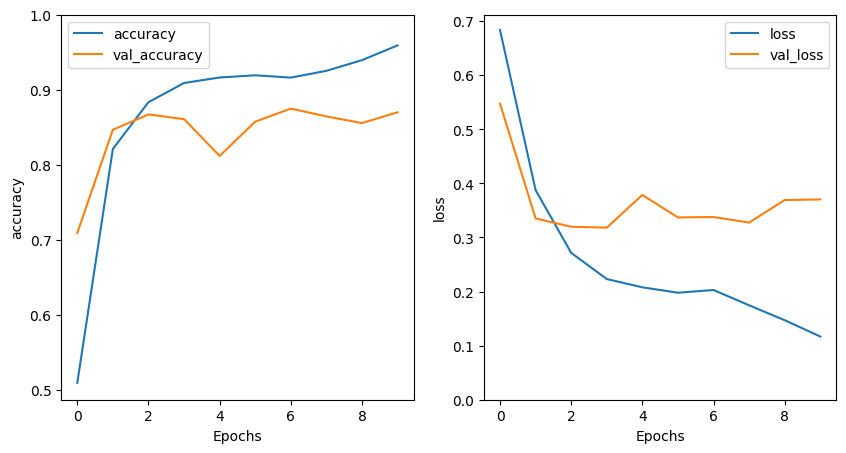

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8473 - loss: 0.4393
Test Loss: 0.43424296379089355
Test Accuracy: 0.8493199944496155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Review: The movie was awesome, wonderful and amazing.
Sentiment: Positive (Confidence: 0.7927)

Review: The movie is bad and a waste of time.
Sentiment: Negative (Confidence: 0.2045)



In [6]:

# Model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, validation_steps=30)

# Plotting function
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

# Plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

samples = np.array([
    'The movie was awesome, wonderful and amazing.',
    'The movie is bad and a waste of time.'
])

sample_ds = tf.data.Dataset.from_tensor_slices(samples).batch(1)

predictions = model.predict(sample_ds)
probabilities = tf.sigmoid(predictions).numpy()

for i, prob in enumerate(probabilities):
    sentiment = "Positive" if prob[0] >= 0.5 else "Negative"
    print(f"Review: {samples[i]}")
    print(f"Sentiment: {sentiment} (Confidence: {prob[0]:.4f})\n")